[Source](https://https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os

In [2]:
from sklearn import metrics

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing

In [4]:
# Mount google drive to have access to images
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive




# **Deep Learning Machine Learning**



In [6]:
img_height = 224
img_width = 224
train_dir = '/content/gdrive/MyDrive/xray/chest_xray/train'
test_dir = '/content/gdrive/MyDrive/xray/chest_xray/test'

In [7]:
# Read IMAGES
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=128)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=128)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=128)

Found 5232 files belonging to 2 classes.
Using 4709 files for training.
Found 5232 files belonging to 2 classes.
Using 523 files for validation.
Found 624 files belonging to 2 classes.


In [8]:
# Prepare test dataset
test_image, test_labels = test_ds.as_numpy_iterator().next()

In [9]:
# Configure the dataset for performance when loading data 
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
# Standardise data
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [41]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, img_width,3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.1)
    # tf.keras.layers.experimental.preprocessing.RandomZoom(0.05),
  ]
)

## Simple CNN ##

In [42]:
del model

Epoch 1/500
37/37 [==============================] - 12s 299ms/step - loss: 4.1596 - binary_accuracy: 0.7090 - val_loss: 3.6447 - val_binary_accuracy: 0.7610
Epoch 2/500
37/37 [==============================] - 11s 298ms/step - loss: 3.8582 - binary_accuracy: 0.7470 - val_loss: 3.6447 - val_binary_accuracy: 0.7610
Epoch 3/500
37/37 [==============================] - 11s 301ms/step - loss: 3.8719 - binary_accuracy: 0.7461 - val_loss: 3.6447 - val_binary_accuracy: 0.7610
Epoch 4/500
37/37 [==============================] - 11s 303ms/step - loss: 3.9361 - binary_accuracy: 0.7419 - val_loss: 3.6447 - val_binary_accuracy: 0.7610
Epoch 5/500
37/37 [==============================] - 11s 302ms/step - loss: 3.9680 - binary_accuracy: 0.7398 - val_loss: 3.6447 - val_binary_accuracy: 0.7610
Epoch 6/500
37/37 [==============================] - 11s 301ms/step - loss: 3.8446 - binary_accuracy: 0.7479 - val_loss: 3.6447 - val_binary_accuracy: 0.7610
Epoch 7/500
37/37 [==============================] -

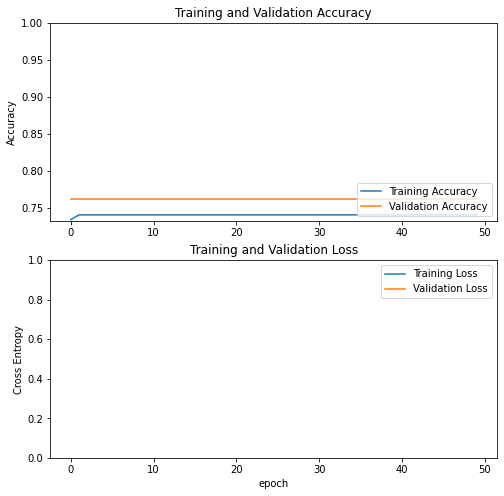

In [43]:
# Try Simple CNN model as baseline
inputs = tf.keras.Input(shape=(img_height, img_width,3)) 
x = data_augmentation(inputs)
x = normalization_layer(x)

x = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu' )(x)
x = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu' )(x)
                           # ,kernel_regularizer=tf.keras.regularizers.L2(0.00001))(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu' )(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu' )(x)
                           # ,kernel_regularizer=tf.keras.regularizers.L2(0.01))(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.models.Model(inputs, outputs)

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), metrics=['binary_accuracy'])
early=tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50, verbose=1, baseline=0.50)
history = model.fit(train_ds, batch_size = 256, epochs= 500, verbose=1, callbacks=[early], 
            validation_data = val_ds)
	
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [44]:
# Evalation

print('MODEL - L2 REGLUARISATION')
predictions = model.predict_on_batch(test_image).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1).numpy()

acc = (predictions ==  test_labels )
print('Accuracy :' ,sum(acc)/len(acc))

confusionMatrix = tf.math.confusion_matrix(
     test_labels , predictions, num_classes=2
).numpy()

# False Negatives = ppl who has pneunomia are predicted as pneunomia free
precision = confusionMatrix[0][0]/(confusionMatrix[0][0]+confusionMatrix[0][1]) #tp/tp+fp
recall = confusionMatrix[0][0]/(confusionMatrix[0][0] + confusionMatrix[1][0]) # tp/tp+fn

print('Precision : ', precision)
print(f'When the model predicts that a person has pnuemonia, {precision}% of time it is correct')
print('Recall : ', recall )
print(f'{recall}% of pnuemonia detected')

MODEL - L2 REGLUARISATION
Accuracy : 0.6328125
[[ 0 47]
 [ 0 81]]
Precision :  0.0
When the model predicts that a person has pnuemonia, 0.0% of time it is correct
Recall :  nan
nan% of pnuemonia detected


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in int_scalars


## Transfer Learning ##

In [45]:
# Preprocessing for pretrained model
preprocess_input = tf.keras.applications.resnet.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
IMG_SHAPE = (224, 224) + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [46]:
# Transfer Learning Model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x =  tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.layers.Dense(1)(x)
x = tf.keras.layers.BatchNormalization()(x)
transfer_model = tf.keras.Model(inputs, outputs)

In [47]:
base_learning_rate = 0.0001
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
# Pre trained model without fine tuning
loss0, accuracy0 = model.evaluate(val_ds)

5/5 [==============================] - 0s 66ms/step - loss: 3.6447 - binary_accuracy: 0.7610


In [49]:
# Fine Tuning
initial_epochs = 20
history = transfer_model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/50
37/37 [==============================] - 21s 471ms/step - loss: 0.6802 - accuracy: 0.5838 - val_loss: 0.6865 - val_accuracy: 0.5086
Epoch 2/50
37/37 [==============================] - 17s 452ms/step - loss: 0.3695 - accuracy: 0.8069 - val_loss: 0.5808 - val_accuracy: 0.6405
Epoch 3/50
37/37 [==============================] - 17s 451ms/step - loss: 0.2912 - accuracy: 0.8610 - val_loss: 0.3809 - val_accuracy: 0.8126
Epoch 4/50
37/37 [==============================] - 17s 450ms/step - loss: 0.2396 - accuracy: 0.9024 - val_loss: 0.3278 - val_accuracy: 0.8547
Epoch 5/50
37/37 [==============================] - 17s 449ms/step - loss: 0.2019 - accuracy: 0.9173 - val_loss: 0.2826 - val_accuracy: 0.8948
Epoch 6/50
37/37 [==============================] - 17s 450ms/step - loss: 0.1968 - accuracy: 0.9265 - val_loss: 0.2413 - val_accuracy: 0.9197
Epoch 7/50
37/37 [==============================] - 17s 450ms/step - loss: 0.1846 - accuracy: 0.9363 - val_loss: 0.1794 - val_accuracy: 0.9484

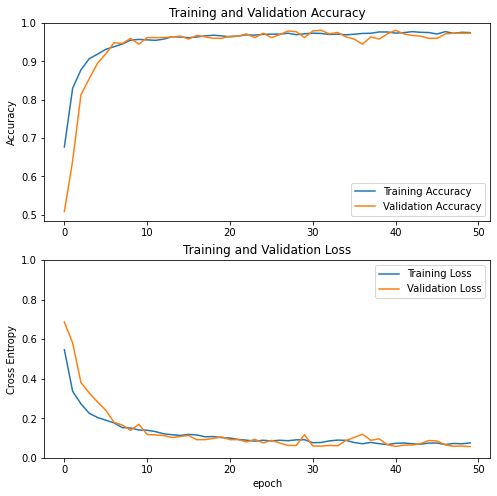

In [50]:
# Training Statistics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [51]:
# Evalation

predictions = transfer_model.predict_on_batch(test_image).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1).numpy()

acc = (predictions ==  test_labels )
print('Accuracy :' ,sum(acc)/len(acc))

confusionMatrix = tf.math.confusion_matrix(
     test_labels , predictions, num_classes=2
).numpy()
print(confusionMatrix)
# False Negatives = ppl who has pneunomia are predicted as pneunomia free
precision = confusionMatrix[0][0]/(confusionMatrix[0][0]+confusionMatrix[0][1]) #tp/tp+fp
recall = confusionMatrix[0][0]/(confusionMatrix[0][0] + confusionMatrix[1][0]) # tp/tp+fn

print('Precision : ', precision)
print(f'When the model predicts that a person has pnuemonia, {precision}% of time it is correct')
print('Recall : ', recall )
print(f'{recall}% of pnuemonia detected')

Accuracy : 0.7734375
[[19 28]
 [ 1 80]]
Precision :  0.40425531914893614
When the model predicts that a person has pnuemonia, 0.40425531914893614% of time it is correct
Recall :  0.95
0.95% of pnuemonia detected


Possibly training set and test set have slightly different image distribution as train and validation set has accuracy of approximately 97% but test set has accuracy of 77.3%